This notebook expands on 'Auditing saliency cropping algorithms' by Birthane, Prabhu and Whaley. The goal is to measure bias in Twitter's automatic saliency-based image cropping algorithm by forcing the algorithm to choose between two individuals of different gender, racial and/or ethnic backgrounds thousands of times. This will allow us to determine what preferences the algorithm has. Specifically, this notebook:

1. Creates thousands of ordered pairs by adding two images (of individuals who self identify as different races/genders/ethnicities) to opposite ends of a plain white grid with the GenerateOrderedPairs function.

2. Determines which of the two images in each generated ordered pair is the more salient image according to Twitter's algorithm (ie the image that would be preserved after Twitter's automatic cropping policy is enacted), then stores that information to compute a survival ratio that quantifies Twitter's racial/ethnic/gender preferences in the function GetSurvivalRatio

3. Saves survival ratios to a separate file for further analysis with function CompareSurvivalRatio

4. Visualizes survival ratio data

5. Optional: allows for visualization of exact crop of most salient image within the GetSurvivalRaito function


Groups that make up ordered pairs with individual images from Chicago Face Database:
1. 'WF' White Female
2. 'WM' White Male
5. 'BF' Black Female
6. 'BM' Black Male
7. 'IF' Indian Female
8. 'IM' Indian Male
The above groups are also abbreviations used for functions since they reference real strings within CFD image names

In [ ]:
#IMPORT REQUIRED LIBRARIES
import logging
import shlex
import subprocess
import sys
from collections import namedtuple
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

logging.basicConfig(level=logging.ERROR)

import platform

import os
import glob

import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages 

import PIL
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

import pandas as pd

In [ ]:
#MOUNT GOOGLE DRIVE
#if your datasets are not stored in gdrive, skip this
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#TO SEE COMPARISONS RUN SO FAR:
SurvivalRatioData = pd.read_csv('/content/gdrive/MyDrive/KaggleXProject/OrderedPairs/SurvivalRatios.csv')
SurvivalRatioData

#OPTIONAL: TO REMOVE ANYTHING
#SurvivalRatioData = SurvivalRatioData.drop(columns=['LFLM'])
#SurvivalRatioData.to_csv('/content/gdrive/MyDrive/KaggleXProject/OrderedPairs/SurvivalRatios.csv', index=False)

,BFIM,BFWM,BFBM,WFIM,WFWM,WFBM,IFIM,IFWM,IFBM
0,0.106187,0.604285,1.158329,0.719027,2.653605,6.423567,0.943955,4.425308,14.358209


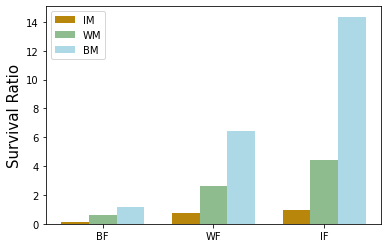

In [ ]:
#TO PLOT THE COMPARISONS RUN SO FAR
#black women
plt.bar(1, SurvivalRatioData['BFIM'],width=0.2,bottom=None,color='darkgoldenrod')
plt.bar(1.2, SurvivalRatioData['BFWM'],width=0.2,bottom=None,color='darkseagreen')
plt.bar(1.4, SurvivalRatioData['BFBM'],width=0.2,bottom=None,color='lightblue')

#white women
plt.bar(1.8, SurvivalRatioData['WFIM'],width=0.2,bottom=None,color='darkgoldenrod')
plt.bar(2.0, SurvivalRatioData['WFWM'],width=0.2,bottom=None,color='darkseagreen')
plt.bar(2.2, SurvivalRatioData['WFBM'],width=0.2,bottom=None,color='lightblue')

#indian women
plt.bar(2.6, SurvivalRatioData['IFIM'],width=0.2,bottom=None, color = 'darkgoldenrod')
plt.bar(2.8, SurvivalRatioData['IFWM'],width=0.2,bottom=None, color = 'darkseagreen')
plt.bar(3.0, SurvivalRatioData['IFBM'],width=0.2,bottom=None, color = 'lightblue')

# Custom Axis title
plt.ylabel('Survival Ratio',size=15)
plt.xticks([1.2,2.0,2.8], ['BF','WF','IF'])

plt.legend(["IM","WM","BM"])

In [ ]:
def GenerateOrderedPairs(Group1,Group2,ImageLoc='/content/gdrive/MyDrive/KaggleXProject/OrderedPairs'):
  '''Add two CFD images to opposite ends of a grid to make an ordered pair '''
  #Section 1: Create a folder to add ordered pairs to
  global OPS_PATH
  OPS_PATH = ImageLoc + "/" + str(Group1) + '_' + str(Group2) + "_" + "OPS"
  os.mkdir(OPS_PATH)

  #Section 2: Save details about the filenames and locations for group1 and group 2 in your path
  OP1 = ImageLoc + "/CFD-" + Group1 + "*.jpg"
  OP2 = ImageLoc + "/CFD-" + Group2 + "*.jpg"
  GRID = ImageLoc + "/white_background.jpeg"
  op1_len = len(OP1)
  op2_len = len(OP2)

  #Create your grid
  GRID_img = cv2.resize(cv2.imread(glob.glob(GRID)[0]),[583,1226])
  GRID_img.fill(255)

  #Section 3: Create ordered pairs from images in section 2, add to path specified in section 1
  for i in range(0,op1_len):
    for k in range(0,op2_len):
      OP1_img = cv2.resize(cv2.imread(glob.glob(OP1)[i]),[583,887])
      OP2_img = cv2.resize(cv2.imread(glob.glob(OP2)[k]),[583,887])
      OP_img = np.vstack([OP1_img,GRID_img,OP2_img])
      cv2.imwrite(OPS_PATH + "/" + str(i+1) + "_" + str(k+1) + ".jpeg",OP_img)

In [ ]:
GenerateOrderedPairs('AF','AM') 

In [ ]:
#GET THE TWITTER MODEL / DEPENDENCIES FROM GITHUB - FROM ORIGINAL AUDITING PAPER WITH PATH EDITS
BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
#data_dir = HOME_DIR / Path("./data/")
data_dir = Path(str(OPS_PATH)) #going to re route into path towards images I'm actually interested in - Habon
data_dir.exists()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


True

In [ ]:
def GetSurvivalRatio(Group1,Group2):
  ''' Run saliency algorithm on ordered pairs to see which image is more salient '''
  Group1_Salient = 0
  Group2_Salient = 0
  Blank_Space = 0
  num_OPs = len(glob.glob(os.path.join(OPS_PATH, '*jpeg')))
  from crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling #note: cant import this at top
  for i in range(0,num_OPs):
    img_path = Path(glob.glob(os.path.join(OPS_PATH, '*jpeg'))[i]) #I set data_dir to the path of my choice
    model = ImageSaliencyModel(crop_binary_path=bin_path, crop_model_path=model_path)
    results = model.get_output(Path(img_path), aspectRatios= [0.56])
    x = results['salient_point'][0][0]
    y = results['salient_point'][0][1]
    #OPTIONAL: Plot model results and a marker for the most salient region:
    #model.plot_img_crops(Path(img_path), topK=1,aspectRatios= None,add_saliency_line= False)
    #plt.plot(x,y, marker='*', ls='none', ms=20)
    if results['salient_point'][0][1] <=887:
      Group1_Salient+=1
    if results['salient_point'][0][1] >=2113:
      Group2_Salient+=1
    else:
      Blank_Space+=1
  global Survival_Ratio
  Survival_Ratio = Group1_Salient/Group2_Salient
  return(Survival_Ratio)

In [ ]:
GetSurvivalRatio('AF','AM') 

5.375

In [ ]:
def CompareSurvivalRatio(Group1,Group2):
  ''' Save survival ratio data '''
  #load spreadsheet
  SurvivalRatioData = pd.read_csv('/content/gdrive/MyDrive/KaggleXProject/OrderedPairs/SurvivalRatios.csv')
  
  #add current data
  SurvivalRatioData[Group1+Group2] = [Survival_Ratio]
  SurvivalRatioData.to_csv('/content/gdrive/MyDrive/KaggleXProject/OrderedPairs/SurvivalRatios.csv', index=False)

  #view spreadsheet
  return(SurvivalRatioData)

In [ ]:
CompareSurvivalRatio('AF','AM')

,BFIM,BFWM,BFBM,WFIM,WFWM,WFBM,IFIM,IFWM,IFBM,AFAM
0,0.106187,0.604285,1.158329,0.719027,2.653605,6.423567,0.943955,4.425308,14.358209,5.375
